In [1]:
import os
import glob
import pandas as pd
import shutil
from datetime import datetime as dt
import datetime

import os
import shutil
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
import gc
import numpy as np
import hickle as hkl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image, ImageDraw

import warnings
warnings.filterwarnings('ignore')

In [2]:
SAT_DIR = '../data/input/test/sat'
EXTERNAL_DIR = '../data/external'

In [3]:
test_info = '../data/input/inference_terms.csv'
test_info_df = pd.read_csv(test_info)
test_info_df.head()

,OpenData_96hr_Start,OpenData_96hr_End,Inference_24hr_Start,Inference_24hr_End,Evaluation_06hr,Evaluation_12hr,Evaluation_18hr,Evaluation_24hr
0,2018/1/2 16:00,2018/1/6 15:00,2018/1/6 16:00,2018/1/7 15:00,2018/1/6 21:00,2018/1/7 3:00,2018/1/7 9:00,2018/1/7 15:00
1,2018/1/9 16:00,2018/1/13 15:00,2018/1/13 16:00,2018/1/14 15:00,2018/1/13 21:00,2018/1/14 3:00,2018/1/14 9:00,2018/1/14 15:00
2,2018/1/16 16:00,2018/1/20 15:00,2018/1/20 16:00,2018/1/21 15:00,2018/1/20 21:00,2018/1/21 3:00,2018/1/21 9:00,2018/1/21 15:00
3,2018/1/23 16:00,2018/1/27 15:00,2018/1/27 16:00,2018/1/28 15:00,2018/1/27 21:00,2018/1/28 3:00,2018/1/28 9:00,2018/1/28 15:00
4,2018/1/30 16:00,2018/2/3 15:00,2018/2/3 16:00,2018/2/4 15:00,2018/2/3 21:00,2018/2/4 3:00,2018/2/4 9:00,2018/2/4 15:00


## 学習に使っていない48時間分を抽出

In [5]:
nt = 60
all_filepaths = []
for end_date in test_info_df.OpenData_96hr_End:
    filepaths = []
    end_date = dt.strptime(end_date, '%Y/%m/%d %H:%M')
    dir_name = end_date.strftime('%Y-%m-%d')
    filename = end_date.strftime('%Y-%m-%d-%H-%M')
    filepath = f'../data/input/test/sat/{dir_name}/{filename}.fv.png'
    filepaths.append(filepath)
    for t in range(1,nt):
        date = end_date - datetime.timedelta(hours=t)
        dir_name = date.strftime('%Y-%m-%d')
        filename = date.strftime('%Y-%m-%d-%H-%M')

        filepath = f'../data/input/test/sat/{dir_name}/{filename}.fv.png'
        filepaths.append(filepath)
        filepaths = sorted(filepaths)
#     for _ in range(0,24):
#         filepaths.append('none')
    all_filepaths += filepaths

In [6]:
resize = 4
desired_im_sz = (512//resize, 672//resize) # (w, h)
DATA_DIR = '../data/features'

cur_loc = 0
test_starts = []

while cur_loc < len(all_filepaths) - nt + 1:
    test_starts.append(cur_loc)
    cur_loc += nt
test_starts
im_list = []
source_list = []
for loc in test_starts:
    source_list += [loc] * nt
print('Creating test data: ' + str(len(all_filepaths)) + ' images')
X = []
for im_file in tqdm(all_filepaths):
    if im_file == 'none':
        img = np.zeros(desired_im_sz)
    else:
        img = cv2.imread(im_file, cv2.IMREAD_GRAYSCALE)
    try:
        img = cv2.resize(img, dsize=desired_im_sz,
                         interpolation=cv2.INTER_CUBIC)
    except:
        split1 = os.path.splitext(im_file)
        split2 = os.path.splitext(split1[0])
        dummy_file = split2[0] + '.dummy' + split2[1] + split1[1]
        img = cv2.imread(dummy_file, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, dsize=desired_im_sz,
                 interpolation=cv2.INTER_CUBIC)
    img = img.tolist()
    X.append(img)
    del img
    gc.collect()
X = np.asarray(X)

  0%|          | 1/3000 [00:00<05:37,  8.89it/s]

Creating test data: 3000 images


100%|██████████| 3000/3000 [17:32<00:00,  2.85it/s]


In [7]:
X = X.reshape(len(all_filepaths), desired_im_sz[1], desired_im_sz[0], 1) # (len, h, w, ch)
print(X.shape)
if not os.path.exists(DATA_DIR): os.mkdir(DATA_DIR)
hkl.dump(X, os.path.join(DATA_DIR, 're4nt36_X_eval.hkl'))
hkl.dump(source_list, os.path.join(
    DATA_DIR, 're4nt36_sources_eval.hkl'))

(3000, 168, 128, 1)


In [25]:
suffix = 're4nt36'
result_dir = '../data/results/'
feature_dir = '../data/features/'

X_hat = hkl.load(os.path.join(result_dir, '{}_X_eval_hat.hkl'.format(suffix)))
X_eval = hkl.load(os.path.join(result_dir, '{}_X_eval.hkl'.format(suffix)))
sources_eval = hkl.load(os.path.join(feature_dir, '{}_sources_eval.hkl'.format(suffix)))

In [19]:
suffix = 'base_model'
result_dir = '../data/results/'
feature_dir = '../data/features/'

X_hat = hkl.load(os.path.join(result_dir, '{}_X_eval_hat.hkl'.format(suffix)))
X_eval = hkl.load(os.path.join(result_dir, '{}_X_eval.hkl'.format(suffix)))
sources_eval = hkl.load(os.path.join(feature_dir, '{}_sources_eval.hkl'.format(suffix)))

In [26]:
# X_hat_file = '../data/results/base_model_X_hat_debug.hkl'
# X_hat = hkl.load(X_hat_file)

img_list = []
for w in X_hat:
    for h in range(41, 60, 6):
#     for h in range(29, 48, 6):
        img = w[h].reshape(168, 128)
        height = img.shape[0]
        width = img.shape[1]
        img = cv2.resize(img , (int(width*4), int(height*4)))
        img = img[40:40+420, 130:130+340]
        img = img * 255
        img = np.array(img, dtype=np.int64)
        img = pd.DataFrame(img)
#         plt.figure(figsize=(8,4))
#         plt.imshow(img, 'gray')
#         plt.show()
        img_list.append(img)
img_df = pd.concat(img_list).reset_index(drop=True)

In [27]:
def resize(img):
    height = img.shape[0]
    width = img.shape[1]
    img = cv2.resize(img , (int(width*4), int(height*4)))
    img = img[40:40+420, 130:130+340]
    img = img * 255
    img = np.array(img, dtype=np.int64)
    
    return img

In [28]:
sources_list = list(test_info_df.OpenData_96hr_Start)

In [38]:
def plot_scores(season, title):
    bat_scores = []
    bat_date = []
    plt.figure()
    for w_hat, w_eval, strdate in zip(X_hat, X_eval, sources_list):
        date = dt.strptime(strdate, '%Y/%m/%d %H:%M')
        if date.month in season:
            mae_list = []
            for h in range(len(w_hat)):
                X_hat_img = w_hat[h].reshape(168, 128)
                X_hat_img = resize(X_hat_img)

                X_eval_img = w_eval[h].reshape(168, 128)
                X_eval_img = resize(X_eval_img)

                a_error = np.absolute(X_eval_img - X_hat_img)
                mae = a_error.mean()

                mae_list.append(mae)
            submit_mae_list = []
#             for h in range(29, 48, 6):
            for h in range(41, 60, 6):
                X_hat_img = w_hat[h].reshape(168, 128)
                X_hat_img = resize(X_hat_img)

                X_eval_img = w_eval[h].reshape(168, 128)
                X_eval_img = resize(X_eval_img)

                a_error = np.absolute(X_eval_img - X_hat_img)
                submit_mae = a_error.mean()
#                 if submit_mae > 35:
                bat_scores.append(submit_mae)
                bat_date.append(strdate)
                
                submit_mae_list.append(submit_mae)

            plt.plot(mae_list[1:])
            plt.ylabel('MAE')
            plt.xlabel('nt')
            plt.title(title)
    submit_mae_mean = np.array(submit_mae_list).mean()
    print(f'submit MAE: {submit_mae_mean:.3f}')
    plt.show()
    
    return bat_scores, bat_date

submit MAE: 30.405


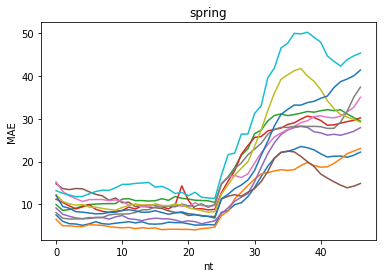

submit MAE: 30.922


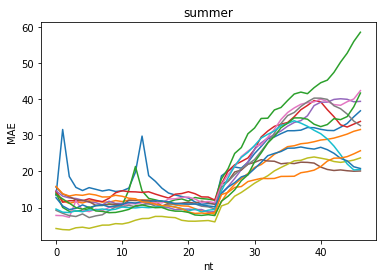

submit MAE: 29.251


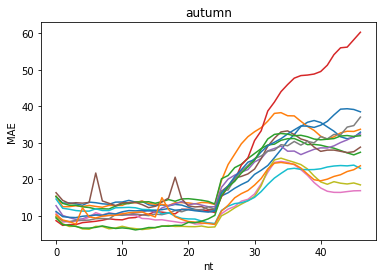

submit MAE: 16.991


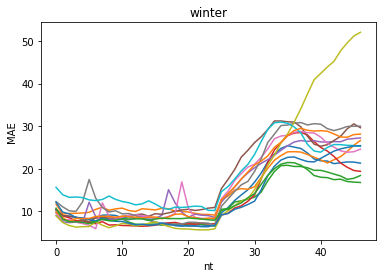

In [24]:
seasons = {'spring': [3, 4, 5],
                  'summer': [6, 7, 8],
                  'autumn': [9, 10, 11],
                  'winter': [12, 1, 2]}

all_bat_scores = []
all_bat_date = []
for season in seasons:
    months = seasons[season]
    bat_scores, bat_date = plot_scores(months, season)
    all_bat_scores += bat_scores
    all_bat_date += bat_date
bad_info_df = pd.DataFrame({'date': all_bat_date,
             'score': all_bat_scores})

submit MAE: 24.584


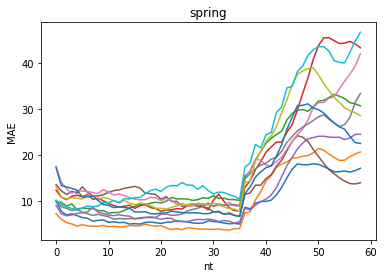

submit MAE: 28.519


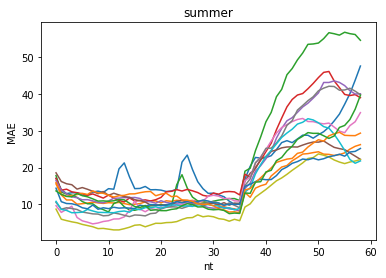

submit MAE: 23.911


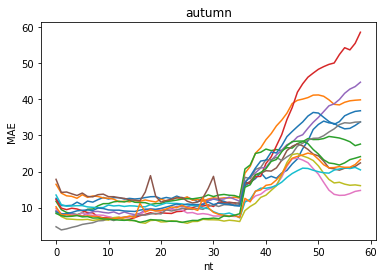

submit MAE: 16.851


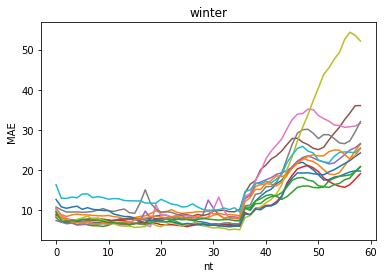

In [39]:
seasons = {'spring': [3, 4, 5],
                  'summer': [6, 7, 8],
                  'autumn': [9, 10, 11],
                  'winter': [12, 1, 2]}

all_bat_scores = []
all_bat_date = []
for season in seasons:
    months = seasons[season]
    bat_scores, bat_date = plot_scores(months, season)
    all_bat_scores += bat_scores
    all_bat_date += bat_date
bad_info_df = pd.DataFrame({'date': all_bat_date,
             'score': all_bat_scores})

MovieWriter imagemagick unavailable.


2018-01-02 16:00:00


MovieWriter imagemagick unavailable.


2018-01-09 16:00:00


MovieWriter imagemagick unavailable.


2018-01-16 16:00:00


MovieWriter imagemagick unavailable.


2018-01-23 16:00:00


MovieWriter imagemagick unavailable.


2018-01-30 16:00:00


MovieWriter imagemagick unavailable.


2018-02-06 16:00:00


MovieWriter imagemagick unavailable.


2018-02-13 16:00:00


MovieWriter imagemagick unavailable.


2018-02-20 16:00:00


MovieWriter imagemagick unavailable.


2018-02-27 16:00:00


MovieWriter imagemagick unavailable.


2018-03-20 16:00:00


MovieWriter imagemagick unavailable.


2018-03-27 16:00:00


MovieWriter imagemagick unavailable.


2018-04-03 16:00:00


MovieWriter imagemagick unavailable.


2018-04-10 16:00:00


MovieWriter imagemagick unavailable.


2018-04-17 16:00:00


MovieWriter imagemagick unavailable.


2018-04-24 16:00:00


MovieWriter imagemagick unavailable.


2018-05-01 16:00:00
2018-05-08 16:00:00


MovieWriter imagemagick unavailable.
MovieWriter imagemagick unavailable.


2018-05-15 16:00:00


MovieWriter imagemagick unavailable.


2018-05-22 16:00:00


MovieWriter imagemagick unavailable.


2018-05-29 16:00:00


MovieWriter imagemagick unavailable.


2018-06-05 16:00:00


MovieWriter imagemagick unavailable.


2018-06-12 16:00:00


MovieWriter imagemagick unavailable.


2018-06-19 16:00:00


MovieWriter imagemagick unavailable.


2018-06-26 16:00:00


MovieWriter imagemagick unavailable.


2018-07-03 16:00:00


MovieWriter imagemagick unavailable.


2018-07-10 16:00:00


MovieWriter imagemagick unavailable.


2018-07-17 16:00:00


MovieWriter imagemagick unavailable.


2018-07-24 16:00:00


MovieWriter imagemagick unavailable.


2018-07-31 16:00:00


MovieWriter imagemagick unavailable.


2018-08-07 16:00:00


MovieWriter imagemagick unavailable.


2018-08-14 16:00:00


MovieWriter imagemagick unavailable.


2018-08-21 16:00:00


MovieWriter imagemagick unavailable.


2018-08-28 16:00:00


MovieWriter imagemagick unavailable.


2018-09-04 16:00:00


MovieWriter imagemagick unavailable.


2018-09-11 16:00:00


MovieWriter imagemagick unavailable.


2018-09-18 16:00:00


MovieWriter imagemagick unavailable.


2018-09-25 16:00:00


MovieWriter imagemagick unavailable.


2018-10-02 16:00:00


MovieWriter imagemagick unavailable.


2018-10-09 16:00:00


MovieWriter imagemagick unavailable.


2018-10-16 16:00:00


MovieWriter imagemagick unavailable.


2018-10-23 16:00:00


MovieWriter imagemagick unavailable.


2018-10-30 16:00:00


MovieWriter imagemagick unavailable.


2018-11-06 16:00:00


MovieWriter imagemagick unavailable.


2018-11-13 16:00:00


MovieWriter imagemagick unavailable.


2018-11-20 16:00:00


MovieWriter imagemagick unavailable.


2018-11-27 16:00:00


MovieWriter imagemagick unavailable.


2018-12-04 16:00:00


MovieWriter imagemagick unavailable.


2018-12-11 16:00:00


MovieWriter imagemagick unavailable.


2018-12-18 16:00:00


MovieWriter imagemagick unavailable.


2018-12-25 16:00:00


<Figure size 432x288 with 0 Axes>

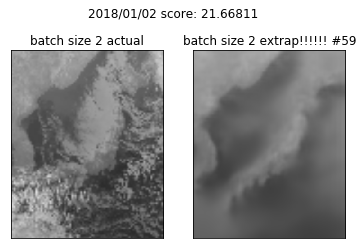

<Figure size 432x288 with 0 Axes>

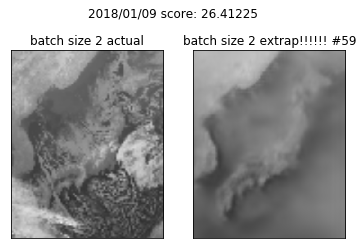

<Figure size 432x288 with 0 Axes>

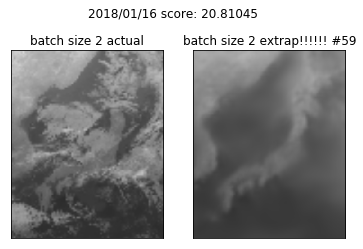

<Figure size 432x288 with 0 Axes>

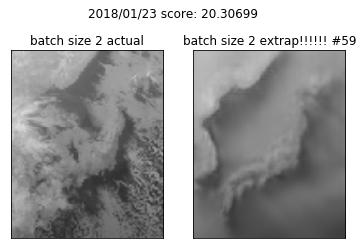

<Figure size 432x288 with 0 Axes>

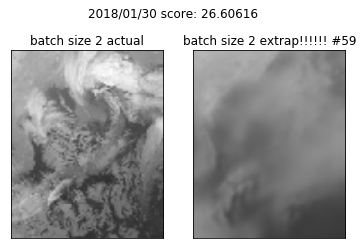

<Figure size 432x288 with 0 Axes>

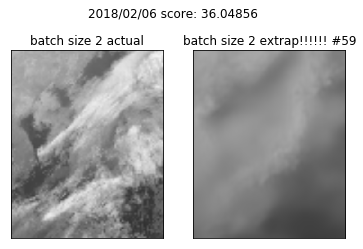

<Figure size 432x288 with 0 Axes>

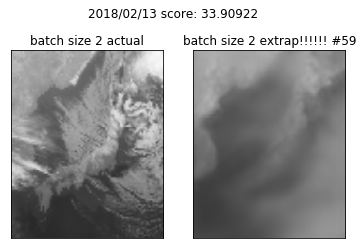

<Figure size 432x288 with 0 Axes>

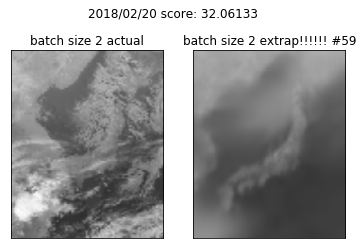

<Figure size 432x288 with 0 Axes>

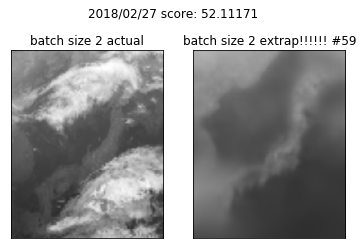

<Figure size 432x288 with 0 Axes>

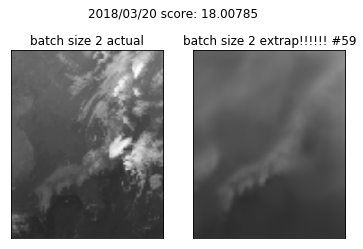

<Figure size 432x288 with 0 Axes>

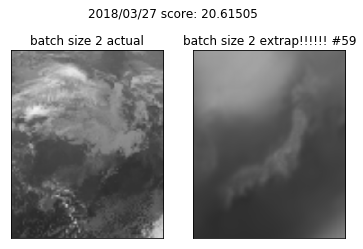

<Figure size 432x288 with 0 Axes>

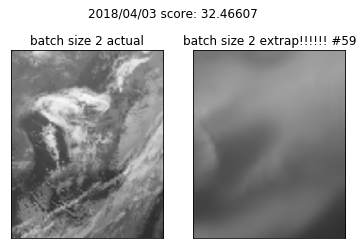

<Figure size 432x288 with 0 Axes>

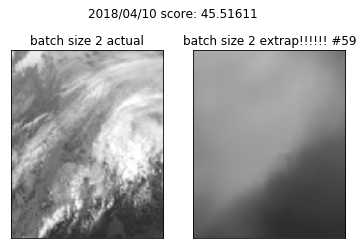

<Figure size 432x288 with 0 Axes>

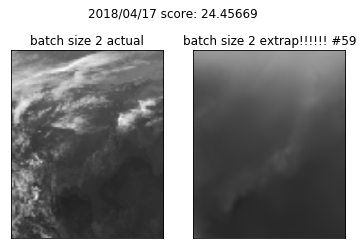

<Figure size 432x288 with 0 Axes>

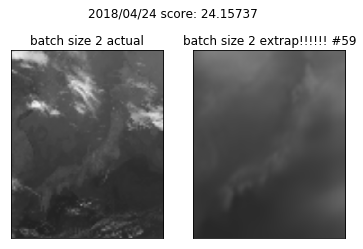

<Figure size 432x288 with 0 Axes>

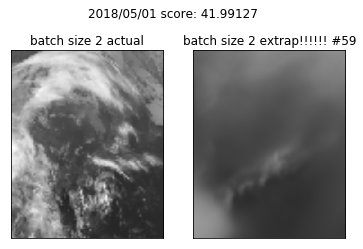

<Figure size 432x288 with 0 Axes>

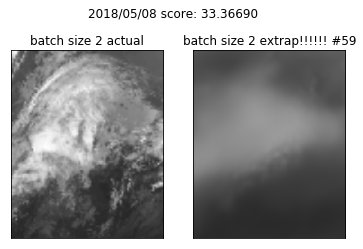

<Figure size 432x288 with 0 Axes>

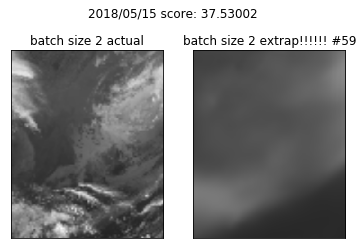

<Figure size 432x288 with 0 Axes>

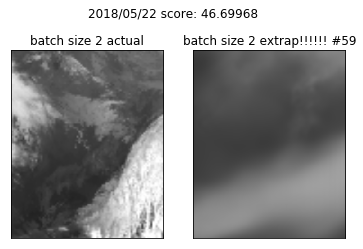

<Figure size 432x288 with 0 Axes>

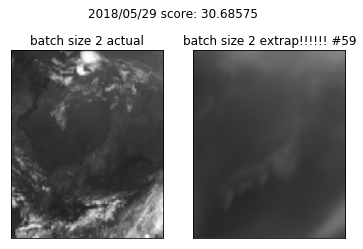

<Figure size 432x288 with 0 Axes>

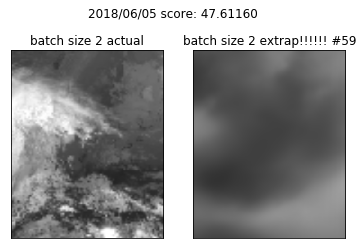

<Figure size 432x288 with 0 Axes>

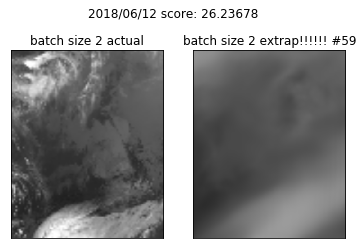

<Figure size 432x288 with 0 Axes>

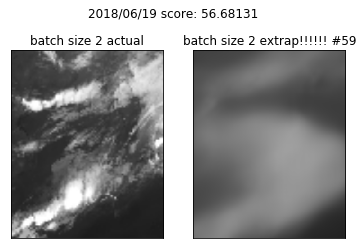

<Figure size 432x288 with 0 Axes>

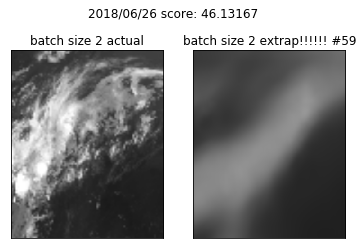

<Figure size 432x288 with 0 Axes>

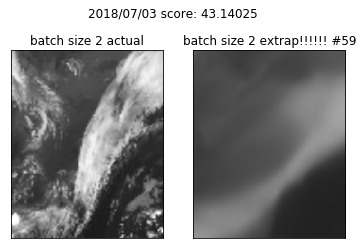

<Figure size 432x288 with 0 Axes>

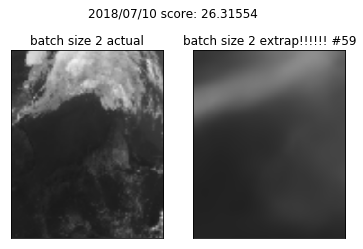

<Figure size 432x288 with 0 Axes>

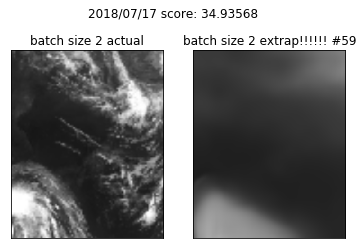

<Figure size 432x288 with 0 Axes>

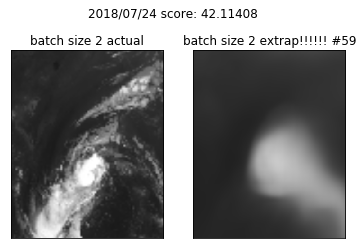

<Figure size 432x288 with 0 Axes>

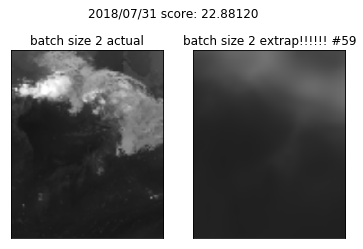

<Figure size 432x288 with 0 Axes>

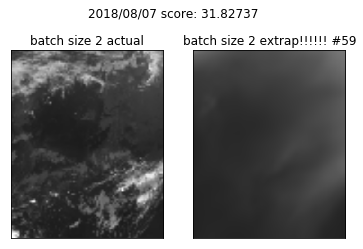

<Figure size 432x288 with 0 Axes>

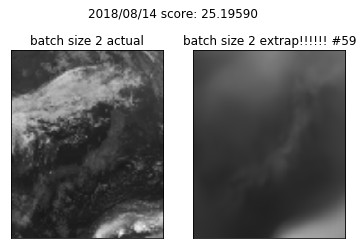

<Figure size 432x288 with 0 Axes>

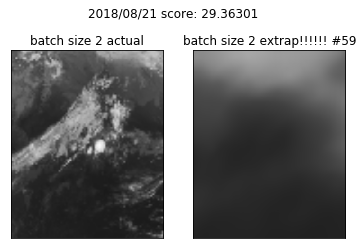

<Figure size 432x288 with 0 Axes>

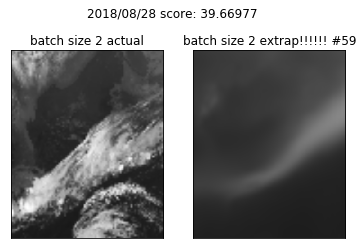

<Figure size 432x288 with 0 Axes>

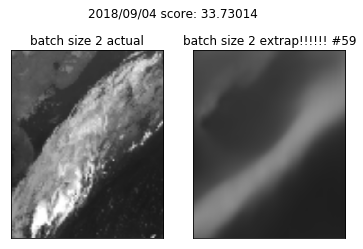

<Figure size 432x288 with 0 Axes>

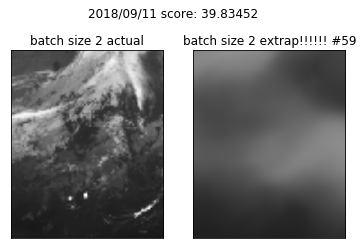

<Figure size 432x288 with 0 Axes>

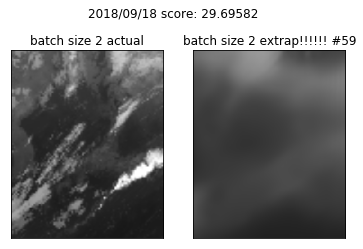

<Figure size 432x288 with 0 Axes>

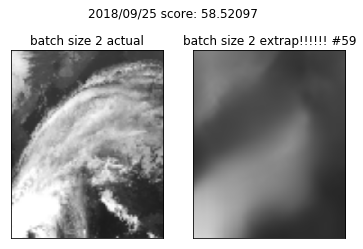

<Figure size 432x288 with 0 Axes>

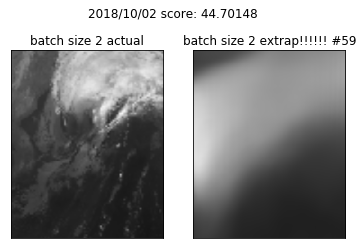

<Figure size 432x288 with 0 Axes>

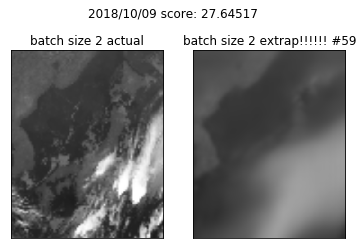

<Figure size 432x288 with 0 Axes>

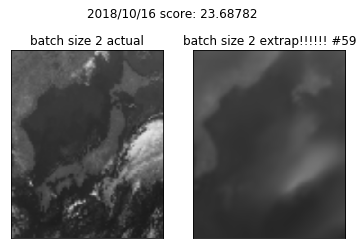

<Figure size 432x288 with 0 Axes>

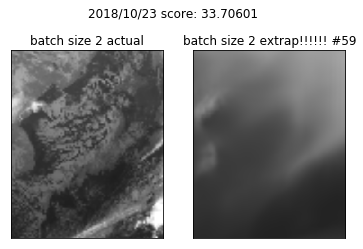

<Figure size 432x288 with 0 Axes>

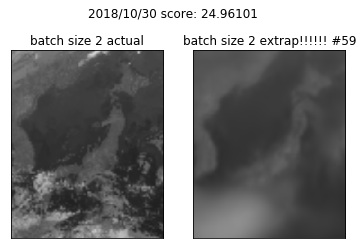

<Figure size 432x288 with 0 Axes>

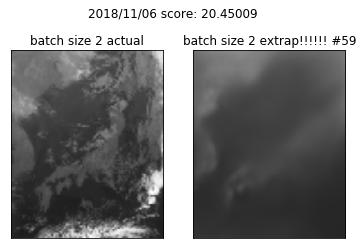

<Figure size 432x288 with 0 Axes>

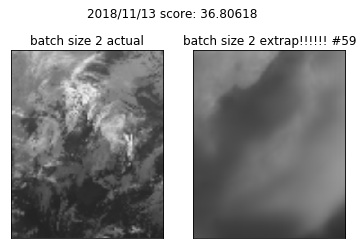

<Figure size 432x288 with 0 Axes>

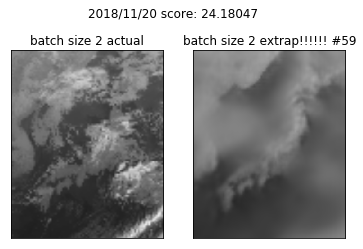

<Figure size 432x288 with 0 Axes>

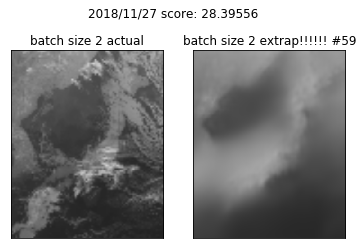

<Figure size 432x288 with 0 Axes>

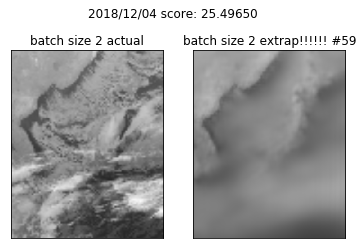

<Figure size 432x288 with 0 Axes>

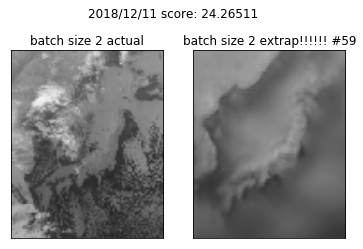

<Figure size 432x288 with 0 Axes>

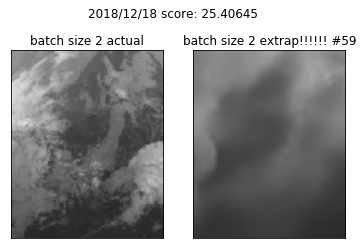

<Figure size 432x288 with 0 Axes>

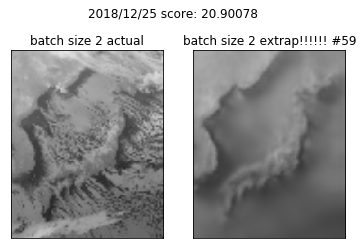

In [47]:
def update(i, w, ax1, ax2):
    re16_hat_file = '../data/results/re4nt36_X_eval.hkl'
    re16_hat = hkl.load(re16_hat_file)
    base_hat_file = '../data/results/re4nt36_X_eval_hat.hkl'
    base_hat = hkl.load(base_hat_file)

    re16_height = re16_hat.shape[2]
    re16_width = re16_hat.shape[3]
    
    re16w = re16_hat[w]
    re16img = re16w[i].reshape(168, 128)
    re16img = cv2.resize(re16img , (int(128*4), int(168*4)))
    re16img = re16img[40:40+420, 130:130+340]
    re16img = re16img * 255
    re16img = Image.fromarray(np.uint8(re16img))
    
    base_w = base_hat[w]
    img = base_w[i].reshape(168, 128)
    img = cv2.resize(img , (int(128*4), int(168*4)))
    img = img[40:40+420, 130:130+340]
    img = img * 255
    img = Image.fromarray(np.uint8(img))
    
    if i != 0:
        plt.cla() #現在描写されているグラフを消去

    ax1.imshow(re16img, animated=True)
#     ax1.set_title('1/4 resized actual')
    ax1.set_title('batch size 2 actual')
    ax1.tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False,
                bottom=False,
                left=False,
                right=False,
                top=False)
    ax2.imshow(img, animated=True)
#     ax2.set_title(f'1/4 resized predicted #{i}')
    ax2.set_title(f'batch size 2 predicted #{i}')
    if i > 36:
#             ax2.set_title(f'1/4 resized  extrap!!!!!! #{i}')
            ax2.set_title(f'batch size 2 extrap!!!!!! #{i}')
    ax2.tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False,
                bottom=False,
                left=False,
                right=False,
                top=False)

def draw(w, date, score):
    fig = plt.figure() 
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6, 4))
    fig.suptitle(f'{date.year}/{date.month:02}/{date.day:02} score: {score:.5f}', fontsize=12)
    month = date.month
    day = date.day

    ani = animation.FuncAnimation(fig, update, fargs = (w, ax1, ax2), interval = 100, frames = 60)
    ani.save(f"../data/bs2/{month:02}{day:02}_bs2.gif", writer = 'imagemagick')

    
if not os.path.exists('../data/bs2'):
    os.mkdir('../data/bs2')

for w, strdate in enumerate(sources_list):
    date = dt.strptime(strdate, '%Y/%m/%d %H:%M')
#     info_df = bad_info_df.copy()
    if strdate in bad_info_df.date.values:
        print(date)
        score = max(bad_info_df[bad_info_df.date == strdate].score.values)
        draw(w, date, score)

In [18]:
mae_list = []
for w_hat, w_eval in zip(X_hat, X_eval):
#     for h in range(29, 48, 6):
    for h in range(41, 60, 6):
        X_hat_img = w_hat[h].reshape(168, 128)
        X_hat_img = resize(X_hat_img)

        X_eval_img = w_eval[h].reshape(168, 128)
        X_eval_img = resize(X_eval_img)

        a_error = np.absolute(X_eval_img - X_hat_img)
        mae = a_error.mean()

        mae_list.append(mae)
np.array(mae_list).mean()

26.33318995098039